In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def eve_distortion(eve_intensities): #from the reconstructed image in uint8 type
    feve_intensities = eve_intensities.astype(np.float)
    fintensities = intensities.astype(np.float)
    dif = (fintensities -  feve_intensities)
    eve_dist_mat = dif**2
    occurance_sum = height*width #?!
    eve_dist = eve_dist_mat.sum()/occurance_sum
    return eve_dist

In [4]:
img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
height = np.shape(intensities)[0]
width = np.shape(intensities)[1]
imf = np.float32(intensities)

all_nq_ac = []
for i in range(0,int(height/8)):
    for j in range(0,int(width/8)):
        blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]
        shifted_blk = blk - 128 #level_shift for dct
        dct = cv2.dct(shifted_blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        
        all_nq_ac = np.append(all_nq_ac, nq_coef_ac)

In [66]:
img_jpg = intensities.astype(np.uint8)
filename = 'lena_jpg.jpg'
cv2.imwrite(filename, img_jpg,[cv2.IMWRITE_JPEG_QUALITY, 100])
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [62]:
ac_values, ac_counts = np.unique(all_nq_ac, return_counts=True)
ac_values_dic = {}
ac_counts_dic = {}
ac_bits_all_sizes = []
for i in range(1,11):
    neg_part = range(-(2**i-1), -2**(i-1)+1)
    pos_part = range(2**(i-1), 2**i)
    values_in_size = np.append(neg_part,pos_part)
    ac_values_dic[i] = values_in_size
    
    counts_in_size = np.zeros(np.size(values_in_size))
    for j in range(np.size(values_in_size)):
        if values_in_size[j] in ac_values:
            position_in_counts = np.where(
                ac_values == values_in_size[j])
            counts_in_size[j] = ac_counts[position_in_counts]
            
    ac_counts_dic[i] = counts_in_size
    
    #Rate
    ac_bits_in_size = sum(counts_in_size)*i
    ac_bits_all_sizes = np.append(ac_bits_all_sizes, ac_bits_in_size)
total_ac_bits = sum(ac_bits_all_sizes)

# JPEG SIZE and AC BITS RATIO

In [67]:
# jpg_size = 88.7 * 8000 # quality 95 as default
jpg_size = 158 * 8000 # # quality 100 as the highest jpeg quality, tif size = 256 kB
ratio = total_ac_bits/jpg_size
print(jpg_size)
print(total_ac_bits)
print(ratio)

1264000
536526.0
0.4244667721518987


In [42]:
# swap between category 1 and cat2
size1 = 1
size2 = 2
argmax_cat1 = np.argmax(ac_counts_dic[size1])
max_cat1 = ac_values_dic[size1][argmax_cat1]
if max_cat1 > 0:
    cat1_old_pair = max_cat1 - 2**(size1-1)-(2**size1-1)
else:
    cat1_old_pair = max_cat1 + 2**(size1-1)+(2**size1-1)
    
argmax_cat2 = np.argmax(ac_counts_dic[size2])
max_cat2 = ac_values_dic[size2][argmax_cat2]
if max_cat2 > 0:
    cat2_old_pair = max_cat2 - 2**(size2-1)-(2**size2-1)
else:
    cat2_old_pair = max_cat2 + 2**(size2-1)+(2**size2-1)

In [46]:
eve_msb0_intensities = np.zeros([height,width])
eve_msb1_intensities = np.zeros([height,width])
for i in range(0,int(height/8)):
    for j in range(0,int(width/8)):
        blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]
        shifted_blk = blk - 128 #level_shift for dct
        dct = cv2.dct(shifted_blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        nq_coef_dc = nq_coef[0,0]
        
        # eve_msb0
        eve_ac_msb0 = nq_coef_ac.copy()
        for m in range(np.size(nq_coef_ac)):
            if nq_coef_ac[m] == max_cat1 and max_cat1 > 0:
                eve_ac_msb0 [m] = max_cat2
            elif nq_coef_ac[m] == max_cat2 and max_cat1 < 0:
                eve_ac_msb0 [m] = max_cat1
            elif nq_coef_ac[m] == cat1_old_pair and cat2_old_pair < 0:
                eve_ac_msb0 [m] = cat2_old_pair
            elif nq_coef_ac[m] == cat2_old_pair and cat2_old_pair > 0:
                eve_ac_msb0 [m] = cat1_old_pair
            elif nq_coef_ac[m] > 0:
                size = np.floor(np.log2(nq_coef_ac[m]))+1
                msb0_pair = nq_coef_ac[m] - 2**(size-1)-(2**size-1)
                eve_ac_msb0 [m] = msb0_pair
                
        eve_msb0_coef1 = np.insert(eve_ac_msb0, 0, nq_coef_dc)
        eve_msb0_coef = np.reshape(eve_msb0_coef1,[8,8])
        
        eve_msb0_blk1 = cv2.idct(eve_msb0_coef)
        eve_msb0_blk2 = eve_msb0_blk1+128 # level_shift after idct
        eve_msb0_blk = np.round(eve_msb0_blk2)  
        eve_msb0_intensities [8*i:8*(i+1), 8*j:8*(j+1)]= eve_msb0_blk
        
        # eve_msb1
        eve_ac_msb1 = nq_coef_ac.copy()
        for m in range(np.size(nq_coef_ac)):
            if nq_coef_ac[m] == max_cat1 and max_cat1 < 0:
                eve_ac_msb0 [m] = max_cat2
            elif nq_coef_ac[m] == max_cat2 and max_cat1 > 0:
                eve_ac_msb0 [m] = max_cat1
            elif nq_coef_ac[m] == cat1_old_pair and cat2_old_pair > 0:
                eve_ac_msb0 [m] = cat2_old_pair
            elif nq_coef_ac[m] == cat2_old_pair and cat2_old_pair < 0:
                eve_ac_msb0 [m] = cat1_old_pair
            elif nq_coef_ac[m] < 0:
                size = np.floor(np.log2(-nq_coef_ac[m]))+1
                msb1_pair = nq_coef_ac[m] + 2**(size-1)+(2**size-1)
                eve_ac_msb1 [m] = msb1_pair
                
        eve_msb1_coef1 = np.insert(eve_ac_msb1, 0, nq_coef_dc)
        eve_msb1_coef = np.reshape(eve_msb1_coef1,[8,8])
        
        eve_msb1_blk1 = cv2.idct(eve_msb1_coef)
        eve_msb1_blk2 = eve_msb1_blk1+128 # level_shift after idct
        eve_msb1_blk = np.round(eve_msb1_blk2)  
        eve_msb1_intensities [8*i:8*(i+1), 8*j:8*(j+1)]= eve_msb1_blk

In [48]:
eve_msb0_uint8 =eve_msb0_intensities.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_1swap_cat1cat2.jpg'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

eve_msb1_uint8 =eve_msb1_intensities.astype(np.uint8)
cv2.imshow('eve_msb1', eve_msb1_uint8)
filename = 'eve_msb1_1swap_cat1cat2.jpg'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb1_uint8)
cv2.imwrite(filename, eve_msb1_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

In [49]:
eve_msb0_dist_db = 10*np.log10(eve_distortion(eve_msb0_intensities))
eve_msb1_dist_db = 10*np.log10(eve_distortion(eve_msb1_intensities))
print(eve_msb0_dist_db)
print(eve_msb1_dist_db)

28.48481864462666
28.063553625941427


In [70]:
# swap between all combinations
eve_msb0_dist_db_dic = {}
eve_msb1_dist_db_dic = {}
new_rates_dic = {}
for size1 in range(1,10):
    eve_msb0_dist_db_all = []
    eve_msb1_dist_db_all = []
    all_new_rates = []
    for size2 in range(size1+1,11):
        argmax_cat1 = np.argmax(ac_counts_dic[size1])
        max_cat1 = ac_values_dic[size1][argmax_cat1]
        if max_cat1 > 0:
            cat1_old_pair = max_cat1 - 2**(size1-1)-(2**size1-1)
        else:
            cat1_old_pair = max_cat1 + 2**(size1-1)+(2**size1-1)

        argmax_cat2 = np.argmax(ac_counts_dic[size2])
        max_cat2 = ac_values_dic[size2][argmax_cat2]
        if max_cat2 > 0:
            cat2_old_pair = max_cat2 - 2**(size2-1)-(2**size2-1)
        else:
            cat2_old_pair = max_cat2 + 2**(size2-1)+(2**size2-1)
            
        eve_msb0_intensities = np.zeros([height,width])
        eve_msb1_intensities = np.zeros([height,width])

        for i in range(0,int(height/8)):
            for j in range(0,int(width/8)):
                blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]
                shifted_blk = blk - 128 #level_shift for dct
                dct = cv2.dct(shifted_blk)
                nq_coef = np.round(dct)
                nq_coef_ac = np.delete(nq_coef, [0,0])
                nq_coef_dc = nq_coef[0,0]

                # eve_msb0
                eve_ac_msb0 = nq_coef_ac.copy()
                for m in range(np.size(nq_coef_ac)):
                    if nq_coef_ac[m] == max_cat1 and max_cat1 > 0:
                        eve_ac_msb0 [m] = max_cat2
                    elif nq_coef_ac[m] == max_cat2 and max_cat1 < 0:
                        eve_ac_msb0 [m] = max_cat1
                    elif nq_coef_ac[m] == cat1_old_pair and cat2_old_pair < 0:
                        eve_ac_msb0 [m] = cat2_old_pair
                    elif nq_coef_ac[m] == cat2_old_pair and cat2_old_pair > 0:
                        eve_ac_msb0 [m] = cat1_old_pair
                    elif nq_coef_ac[m] > 0:
                        size = np.floor(np.log2(nq_coef_ac[m]))+1
                        msb0_pair = nq_coef_ac[m] - 2**(size-1)-(2**size-1)
                        eve_ac_msb0 [m] = msb0_pair

                eve_msb0_coef1 = np.insert(eve_ac_msb0, 0, nq_coef_dc)
                eve_msb0_coef = np.reshape(eve_msb0_coef1,[8,8])

                eve_msb0_blk1 = cv2.idct(eve_msb0_coef)
                eve_msb0_blk2 = eve_msb0_blk1+128 # level_shift after idct
                eve_msb0_blk = np.round(eve_msb0_blk2)  
                eve_msb0_intensities [8*i:8*(i+1), 8*j:8*(j+1)]= eve_msb0_blk

                # eve_msb1
                eve_ac_msb1 = nq_coef_ac.copy()
                for m in range(np.size(nq_coef_ac)):
                    if nq_coef_ac[m] == max_cat1 and max_cat1 < 0:
                        eve_ac_msb1 [m] = max_cat2
                    elif nq_coef_ac[m] == max_cat2 and max_cat1 > 0:
                        eve_ac_msb1 [m] = max_cat1
                    elif nq_coef_ac[m] == cat1_old_pair and cat2_old_pair > 0:
                        eve_ac_msb1 [m] = cat2_old_pair
                    elif nq_coef_ac[m] == cat2_old_pair and cat2_old_pair < 0:
                        eve_ac_msb1 [m] = cat1_old_pair
                    elif nq_coef_ac[m] < 0:
                        size = np.floor(np.log2(-nq_coef_ac[m]))+1
                        msb1_pair = nq_coef_ac[m] + 2**(size-1)+(2**size-1)
                        eve_ac_msb1 [m] = msb1_pair

                eve_msb1_coef1 = np.insert(eve_ac_msb1, 0, nq_coef_dc)
                eve_msb1_coef = np.reshape(eve_msb1_coef1,[8,8])

                eve_msb1_blk1 = cv2.idct(eve_msb1_coef)
                eve_msb1_blk2 = eve_msb1_blk1+128 # level_shift after idct
                eve_msb1_blk = np.round(eve_msb1_blk2)  
                eve_msb1_intensities [8*i:8*(i+1), 8*j:8*(j+1)]= eve_msb1_blk

        eve_msb0_uint8 =eve_msb0_intensities.astype(np.uint8)
        cv2.imshow('eve_msb0', eve_msb0_uint8)
        filename = 'eve_msb0_1swap_cat'\
                     +str(size1)+'cat'+str(size2)+'.jpg'
        cv2.imwrite(filename, eve_msb0_uint8)
        cv2.waitKey(1000)

        eve_msb1_uint8 =eve_msb1_intensities.astype(np.uint8)
        cv2.imshow('eve_msb1', eve_msb1_uint8)
        filename = 'eve_msb1_1swap_cat'\
                     +str(size1)+'cat'+str(size2)+'.jpg'
        cv2.imwrite(filename, eve_msb1_uint8)
        cv2.waitKey(1000)

        cv2.destroyAllWindows()

        eve_msb0_dist_db \
                = 10*np.log10(eve_distortion(eve_msb0_intensities))
        eve_msb0_dist_db_all \
                = np.append(eve_msb0_dist_db_all, eve_msb0_dist_db)
        eve_msb1_dist_db \
                = 10*np.log10(eve_distortion(eve_msb1_intensities))
        eve_msb1_dist_db_all \
                = np.append(eve_msb1_dist_db_all, eve_msb1_dist_db)
        
        
        # Rate increase
        arg_cat1_old_pair = np.where(ac_values_dic[size1] == cat1_old_pair)
        new_rate = total_ac_bits\
                 - ac_counts_dic[size2][argmax_cat2]*size2\
                 + ac_counts_dic[size2][argmax_cat2]*size1\
                 - ac_counts_dic[size1][arg_cat1_old_pair]*size1\
                 + ac_counts_dic[size1][arg_cat1_old_pair]*size2
        all_new_rates = np.append(all_new_rates, new_rate)

    eve_msb0_dist_db_dic[size1] = eve_msb0_dist_db_all
    eve_msb1_dist_db_dic[size1] = eve_msb1_dist_db_all
    
    new_rates_dic[size1] = all_new_rates

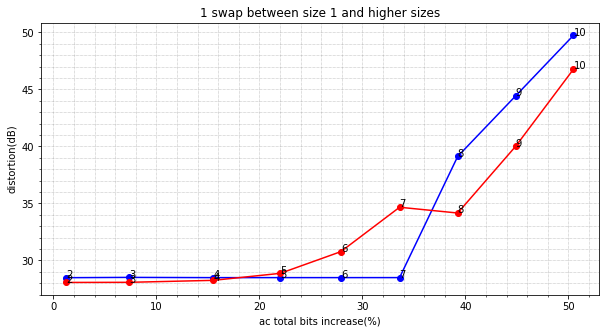

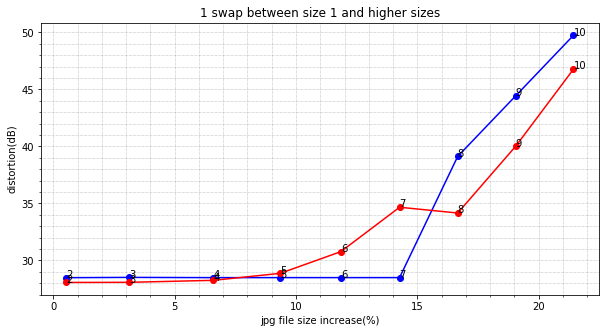

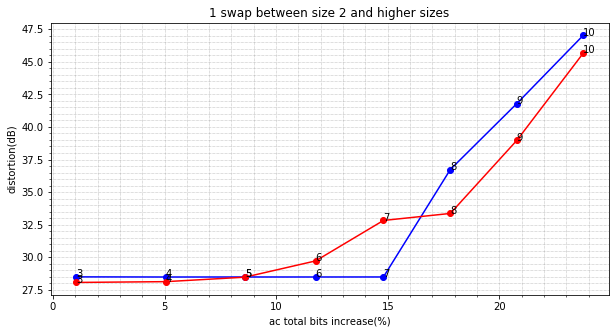

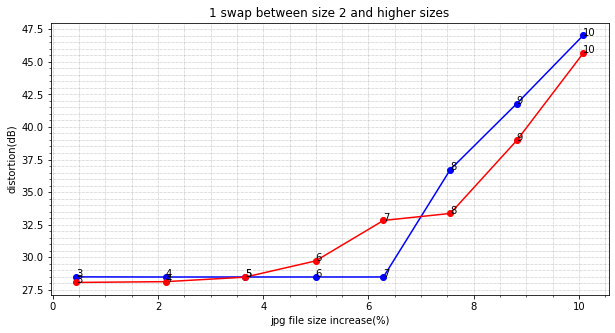

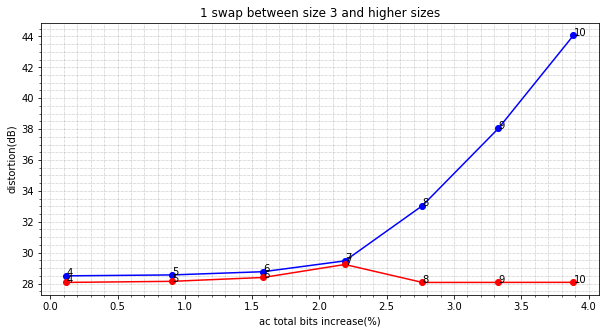

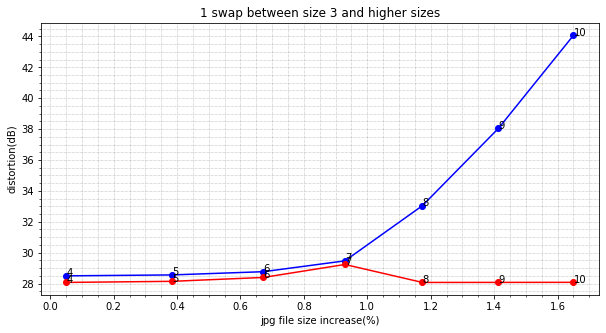

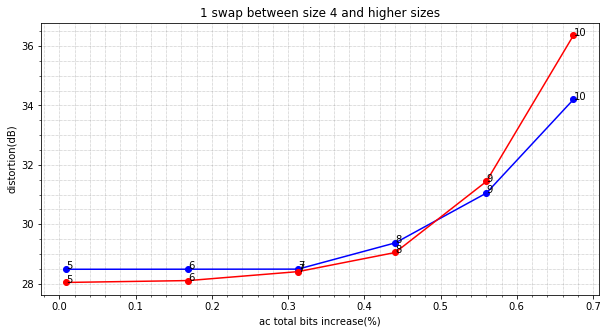

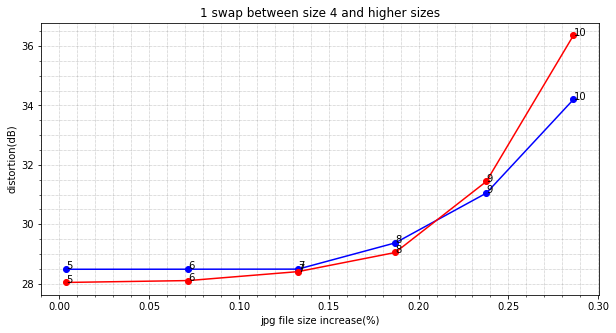

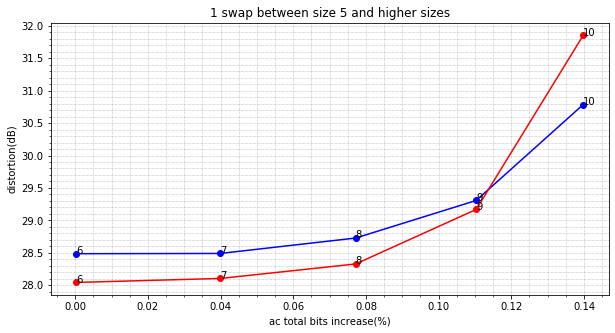

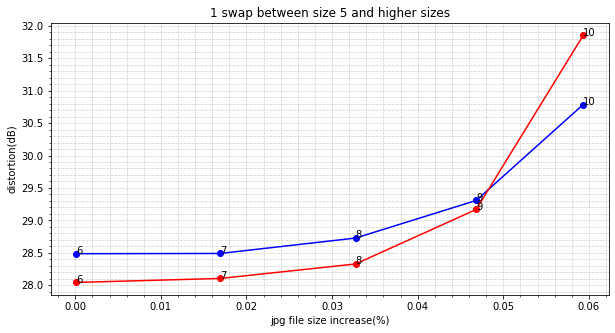

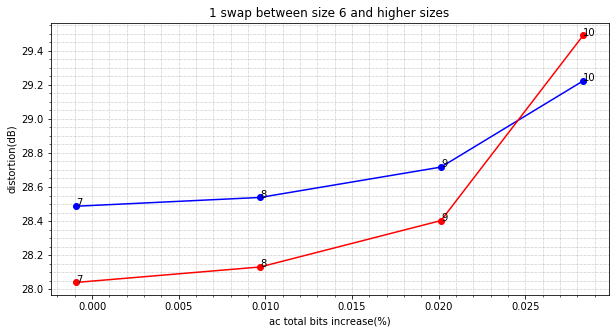

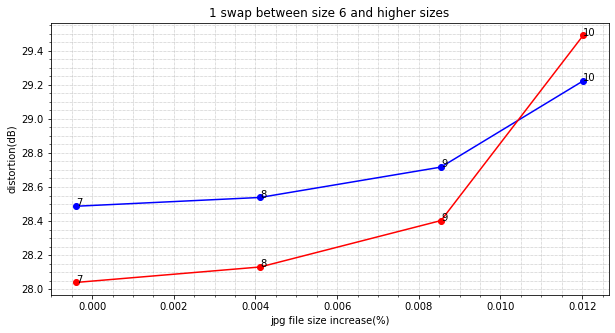

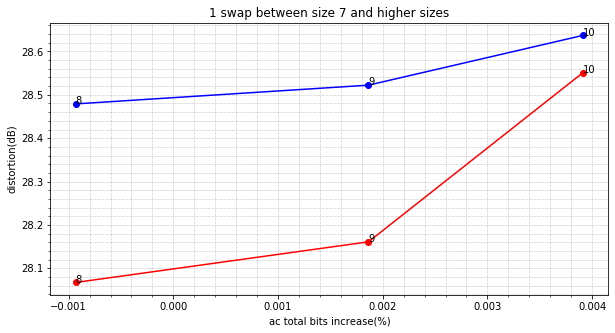

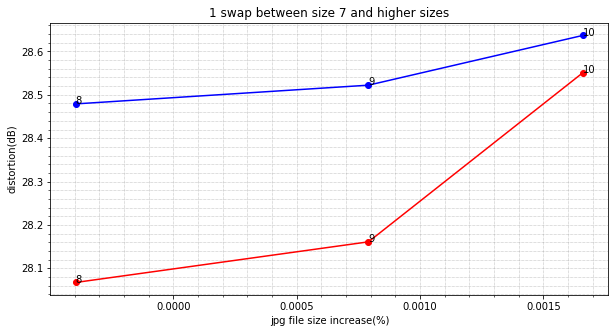

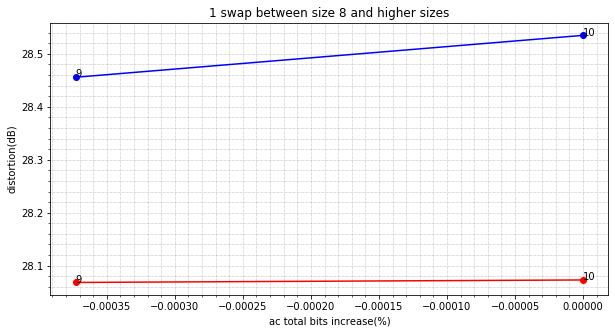

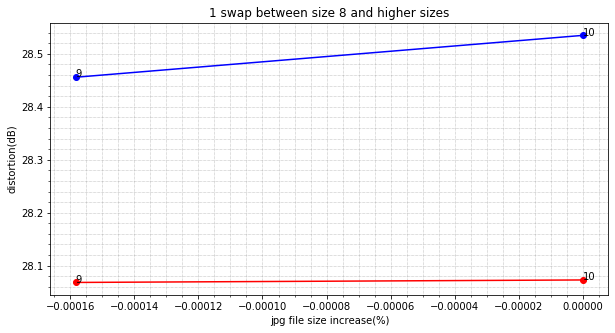

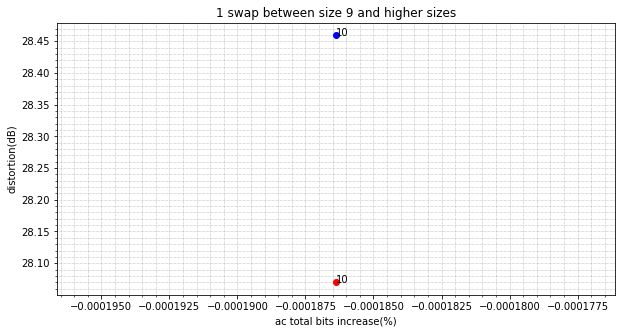

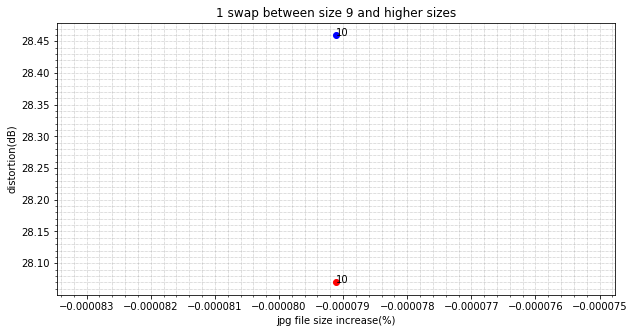

In [152]:
for size1 in range(1,10):
    ac_bits_increase = (new_rates_dic[size1]-total_ac_bits)/total_ac_bits*100
    # jpg_size = 158 * 8000 = 1264000 # # quality 100 as the highest jpeg quality
    new_jpg_size = jpg_size-total_ac_bits+new_rates_dic[size1]
    jpg_size_increase = (new_jpg_size-jpg_size)/jpg_size*100

    
    plt.figure(figsize=(10,5))
    plt.plot(ac_bits_increase, eve_msb0_dist_db_dic[size1],'-ok', color = 'blue')
    plt.plot(ac_bits_increase, eve_msb1_dist_db_dic[size1],'-ok', color = 'red')

    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.xlabel('ac total bits increase(%)')
    plt.ylabel('distortion(dB)')
    plt.title('1 swap between size '+str(size1)+' and higher sizes')
    for i in range(size1,10):
        plt.annotate(i+1,(ac_bits_increase[i-size1],
                              eve_msb0_dist_db_dic[size1][i-size1]))
        plt.annotate(i+1,(ac_bits_increase[i-size1],
                              eve_msb1_dist_db_dic[size1][i-size1]))
    plt.savefig('ac_bits_1swap_size'+str(size1)+'_higher.pdf')
    plt.savefig('ac_bits_1swap_size'+str(size1)+'_higher.png')
    

    plt.figure(figsize=(10,5))
    plt.plot(jpg_size_increase, eve_msb0_dist_db_dic[size1],'-ok', color = 'blue')
    plt.plot(jpg_size_increase, eve_msb1_dist_db_dic[size1],'-ok', color = 'red')

    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.xlabel('jpg file size increase(%)')
    plt.ylabel('distortion(dB)')
    plt.title('1 swap between size '+str(size1)+' and higher sizes')
    for i in range(size1,10):
        plt.annotate(i+1,(jpg_size_increase[i-size1],
                              eve_msb0_dist_db_dic[size1][i-size1]))
        plt.annotate(i+1,(jpg_size_increase[i-size1],
                              eve_msb1_dist_db_dic[size1][i-size1]))
    plt.savefig('jpg_size_1swap_size'+str(size1)+'_higher.pdf')
    plt.savefig('jpg_size_1swap_size'+str(size1)+'_higher.png')

In [153]:
ac_values_dic[1]

array([-1,  1])

In [154]:
ac_counts_dic[1]

array([30468., 30106.])